In [1]:
import os

import h5py
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax import vmap, config

from jax_sph.kernel import QuinticKernel
from jax_sph.turbulence import (
    M4PrimeKernel,
    get_real_wavenumber_grid,
    get_energy_spectrum,
    sph_fourier_transformation,
)
from jax_sph.math import (
    gaussian_pdf_jax,
    gaussian_cdf_jax,
    erf_jax,
    erfc_jax,
    factorial_jax,
)

EPS = jnp.finfo(float).eps
config.update("jax_enable_x64", True)

In [3]:
t = np.linspace(0, 3, 100)
k = np.linspace(1, 50, 50)
kernels = [(M4PrimeKernel, 1), (QuinticKernel, 1)]
w = []
w_fourier = []
for j in kernels:
    kernel_fn = j[0](j[1], 1)
    temp = vmap(kernel_fn.w)(t)
    w.append(temp)
    w_fourier.append(np.fft.fft(temp))


N = len(w_fourier[0])
n = np.arange(N)
T = N/100
freq = n/T 


Show M4' kernel versus quintic spline kernel in physical and fourier domain

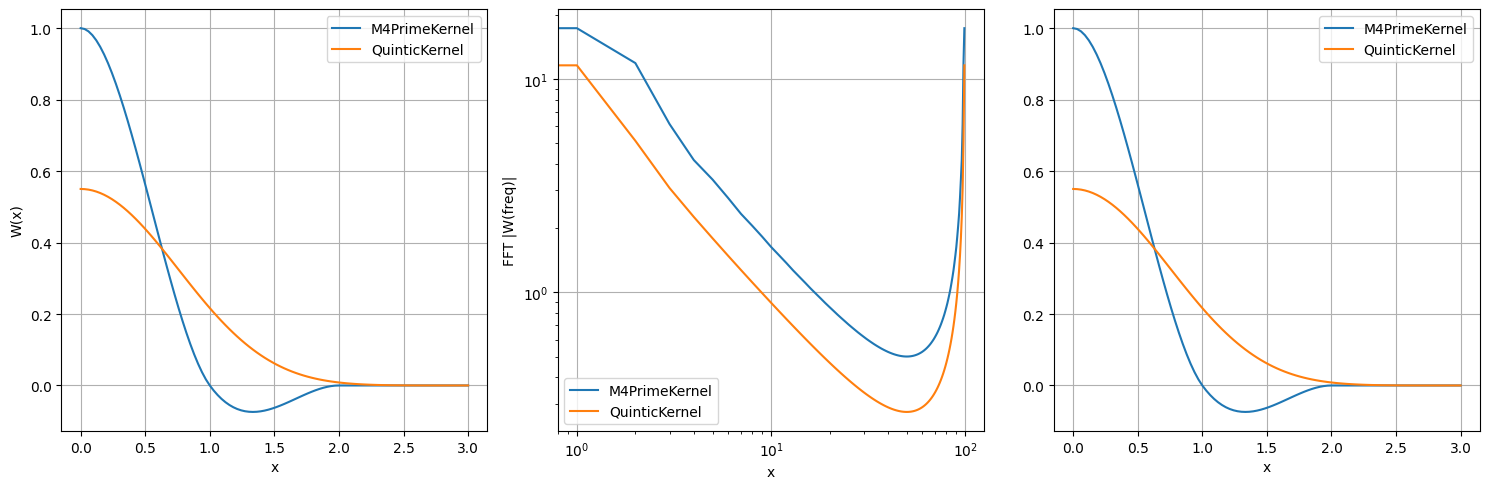

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(jnp.shape(w)[0]):
    axs[0].plot(t, w[i], label=str(kernels[i][0].__name__))
    axs[1].plot(freq, np.abs(w_fourier[i]), label=str(kernels[i][0].__name__))
    axs[2].plot(t, np.fft.ifft(w_fourier[i]), label=str(kernels[i][0].__name__))

for ax in axs:
    ax.set_xlabel("x")
    ax.legend()
    ax.grid()

axs[0].set_ylabel("W(x)")
axs[1].set_ylabel("FFT |W(freq)|")
axs[1].set_yscale('log')
axs[1].set_xscale('log')
plt.tight_layout()
plt.show()

Energy spcetrum computation in 3D and 2D

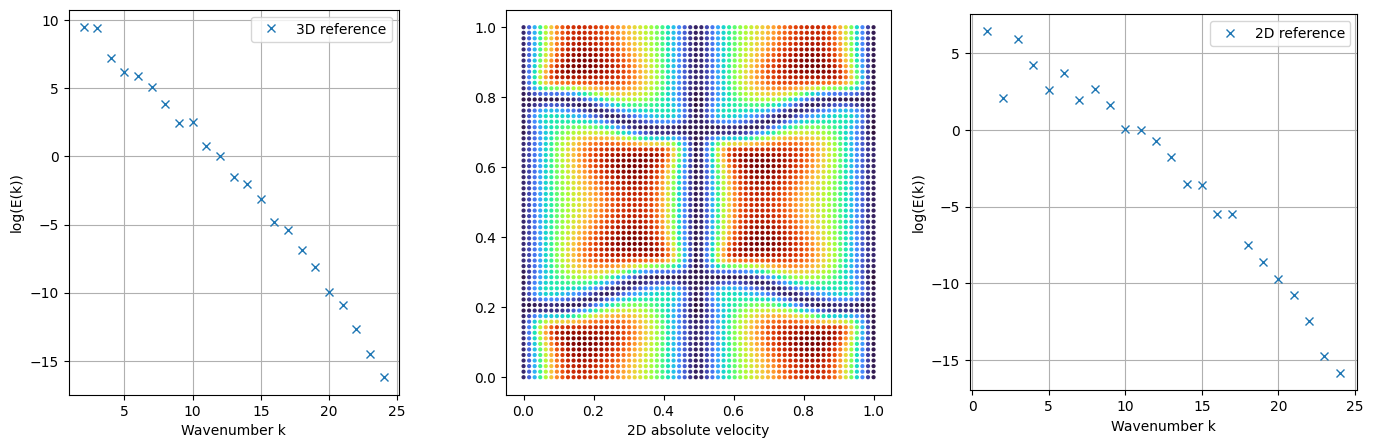

In [6]:
def mask_for_plot(masked_array):
        x = np.arange(len(masked_array))
        x = x[~masked_array.mask]
        y = masked_array.data[~masked_array.mask]
        mask2 = y > -17
        x = x[mask2]
        y = y[mask2]
        return x, y

# read velocity tensor from h5py file (5s into TGV with Re=100 on 64^3 grid)
# obtained using JAX-FLUIDS
vel = h5py.File(os.path.join("./ref_data", "tgv_vel_64.h5"), "r")["velocity"][:]

# slice for 2D solution
vel_2d = vel[:2, 0]
vel_2d_abs = np.sum(vel_2d**2, axis=0)
t = np.linspace(0, 1, 64)
x, y = np.meshgrid(t, t, indexing="ij")

# compute reference energy spectrum
ek_ref_3d = get_energy_spectrum(vel)
ek_ref_2d = get_energy_spectrum(vel_2d)

# plot results
fig, axs = plt.subplots(1, 3, figsize=(17, 5))
axs[0].plot(*mask_for_plot(np.ma.log(ek_ref_3d)), 'x', label="3D reference")
axs[0].legend()
axs[0].set_ylabel("log(E(k))")
axs[0].set_xlabel("Wavenumber k")
axs[0].grid()
axs[0].set_aspect('equal', 'box')

axs[1].scatter(x, y, c=vel_2d_abs, cmap="turbo", s=4)
axs[1].set_aspect('equal', 'box')
axs[1].set_xlabel("2D absolute velocity")

axs[2].plot(*mask_for_plot(np.ma.log(ek_ref_2d)), 'x', label="2D reference")
axs[2].legend()
axs[2].set_ylabel("log(E(k))")
axs[2].set_xlabel("Wavenumber k")
axs[2].grid()
axs[2].set_aspect('equal', 'box')
plt.show()

In [ ]:
# sampling rate
sr = 2000
# sampling interval
ts = 1.0/sr
t = np.arange(0,1,ts)

freq = 1.
x = 3*np.sin(2*np.pi*freq*t)

freq = 4
x += np.sin(2*np.pi*freq*t)

freq = 7   
x += 0.5* np.sin(2*np.pi*freq*t)

plt.figure(figsize = (8, 6))
plt.plot(t, x, 'r')
plt.ylabel('Amplitude')

plt.show()

In [ ]:
X = np.fft.fft(x)
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

k1 = np.arange(N/2) 
k2 = np.arange(-N/2, 0)
k = np.append(k1, k2)
print(np.max(np.fft.fftfreq(N, ts)-k))
r = np.linspace(0, 1, N)
m = np.ones_like(r) / N
rho = np.ones_like(r)

X_new = sph_fourier_transformation(x, r, m, rho, 0.5, k)
print(len(X_new))



plt.figure(figsize = (18, 6))
plt.subplot(131)

plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
#plt.xlim(0, 10)

plt.subplot(132)
plt.stem(freq, np.abs(X_new), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')

plt.subplot(133)
plt.plot(t, np.fft.ifft(X_new), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

Plot of the jax implemented gaussian PDF, CDF, erf, and erfc functions

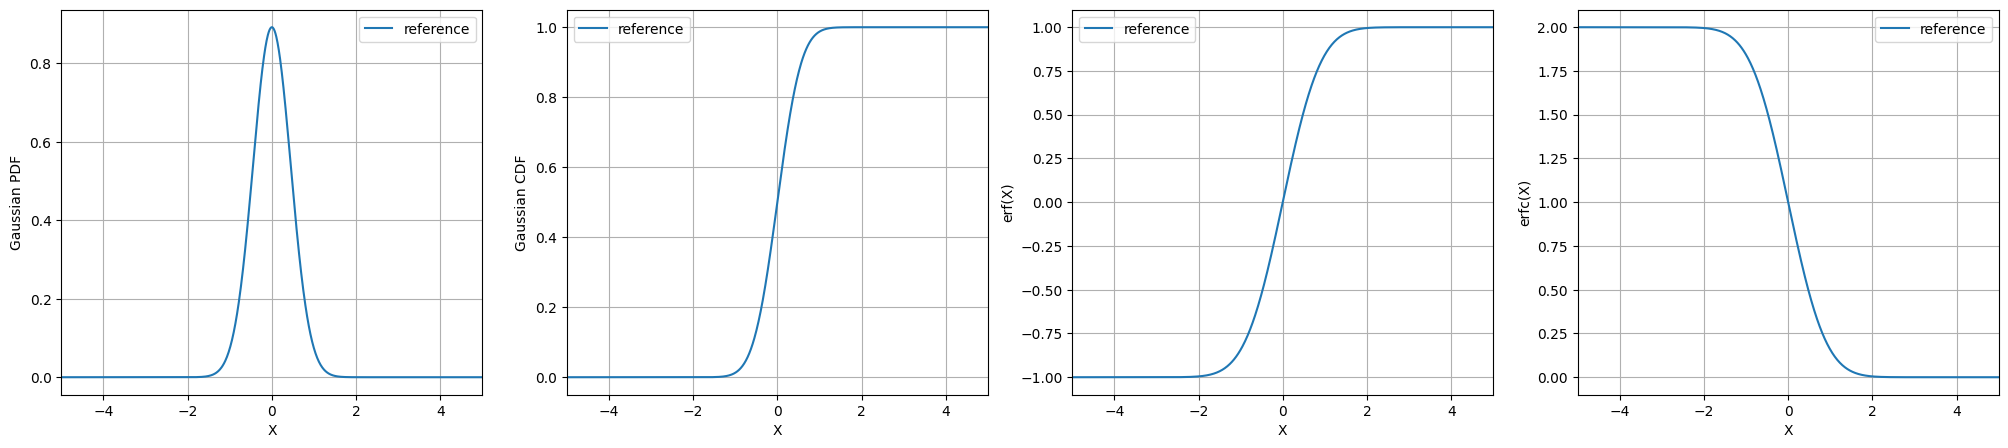

In [20]:
# define parameters
x = np.linspace(-5, 5, 1000)
sigma = np.sqrt(0.2)
mu = 0

# compute erf and erfc
erf  = vmap(erf_jax)(x)
erfc = vmap(erfc_jax)(x)

# compute PDF
pdf = gaussian_pdf_jax(x, mu, sigma)

# compute CDF
cdf = gaussian_cdf_jax(x, mu, sigma)

# plot results
fig, ax = plt.subplots(1, 4, figsize=(25, 5))
ax[0].plot(x, pdf, label="reference")
ax[0].legend()
ax[0].set_ylabel("Gaussian PDF")
ax[0].set_xlabel("X")
ax[0].set_xlim(-5, 5)
ax[0].grid()

ax[1].plot(x, cdf, label="reference")
ax[1].legend()
ax[1].set_ylabel("Gaussian CDF")
ax[1].set_xlabel("X")
ax[1].set_xlim(-5, 5)
ax[1].set_ylim(-0.05, 1.05)
ax[1].grid()

ax[2].plot(x, erf, label="reference")
ax[2].legend()
ax[2].set_ylabel("erf(X)")
ax[2].set_xlabel("X")
ax[2].set_xlim(-5, 5)
ax[2].set_ylim(-1.1, 1.1)
ax[2].grid()

ax[3].plot(x, erfc, label="reference")
ax[3].legend()
ax[3].set_ylabel("erfc(X)")
ax[3].set_xlabel("X")
ax[3].set_xlim(-5, 5)
ax[3].set_ylim(-0.1, 2.1)
ax[3].grid()
plt.show()